In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from Aggregation import Agregator
import matplotlib.pyplot as plt
from functools import partial
from sklearn.metrics.pairwise import rbf_kernel
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

In [4]:
def plot_all(aggregate,X,y_target,y_good,y_bad,trick_data,f_target):
    idx=np.argsort(X)
    X_eval_sorted=X[idx]
    Y_eval_sorted=y_target[idx]
    pred_aggregate_sorted,alpha=aggregate.predict(X_eval_sorted[:,None],return_alpha=True)
    #two plot one on top of the other. first one is evolution of the aggregate, second evolution of alpha

    fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1,figsize=(10,10))


    ax1.set_xlabel('X')
    ax1.set_ylabel('aggregate')
    ax1.tick_params(axis='y')
    for y,model_name in [(y_good,'good'),(y_bad,'bad')]:
        ax1.plot(X_eval_sorted,y[idx],label=model_name,linestyle='--')
    ax1.plot(X_eval_sorted,Y_eval_sorted,label='data')
    ax1.plot(X_eval_sorted,pred_aggregate_sorted,label='aggregate')
    ax1.scatter(trick_data,f_target(trick_data),label='trick_data')
    #ax2 must be a new subplot



    ax2.set_ylabel('alpha')  # we already handled the x-label with ax1
    for i,model in enumerate(['good','bad']):
        ax2.plot(X_eval_sorted, alpha[i], label=model)
    ax2.tick_params(axis='y')
    ax1.legend()
    ax2.legend()
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    return fig

In [5]:
class wrapper:
    def __init__(self, func, *args, **kwargs):
        self.func = func
        self.args = args
        self.kwargs = kwargs
    def predict(self, x):
        return self.func(x)[:,0]

# Example 1

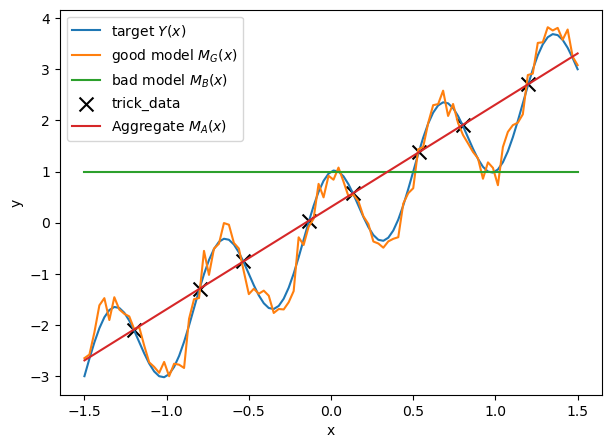

In [28]:
np.random.seed(0)
f_target= lambda x:2*x+np.cos(3*np.pi*x)
good_model=lambda x:f_target(x)+np.random.normal(0,0.2,size=x.shape)
bad_model=lambda x:np.ones_like(x)
X=np.linspace(-1.5,1.5,100)
y_target=f_target(X)
y_good=good_model(X)
y_bad=bad_model(X)

phi=0.2
trick_data=np.array([-1+phi+2*k/3 for k in range(4)]+[1-phi-2*k/3 for k in range(4)])
intercept=f_target(trick_data)[0]-2*trick_data[0]

#plot
plt.figure(figsize=(7,5))
plt.plot(X,y_target,label='target $Y(x)$')
plt.plot(X,y_good,label='good model $M_G(x)$')
plt.plot(X,y_bad,label='bad model $M_B(x)$')
#plot trick data at the forefront
plt.scatter(trick_data,f_target(trick_data),label='trick_data',c='k',s=100,marker='x')#,zorder=10)
plt.plot(X,2*X+intercept,label='Aggregate $M_A(x)$')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [227]:
def linear_separable_kernel(x,y,mat):
    K=x@y.T
    return K[:,:,None,None]*mat[None,None,:,:]

my_kernel=partial(linear_separable_kernel,mat=np.eye(2))

In [228]:
aggregate=Agregator(K=my_kernel,models=[wrapper(good_model),wrapper(bad_model)],kernel_name='linear',intercept_choice='fit')

# No noise, No regularization

In [229]:
aggregate=aggregate.fit(trick_data[:,None],f_target(trick_data),alpha=1e-4)

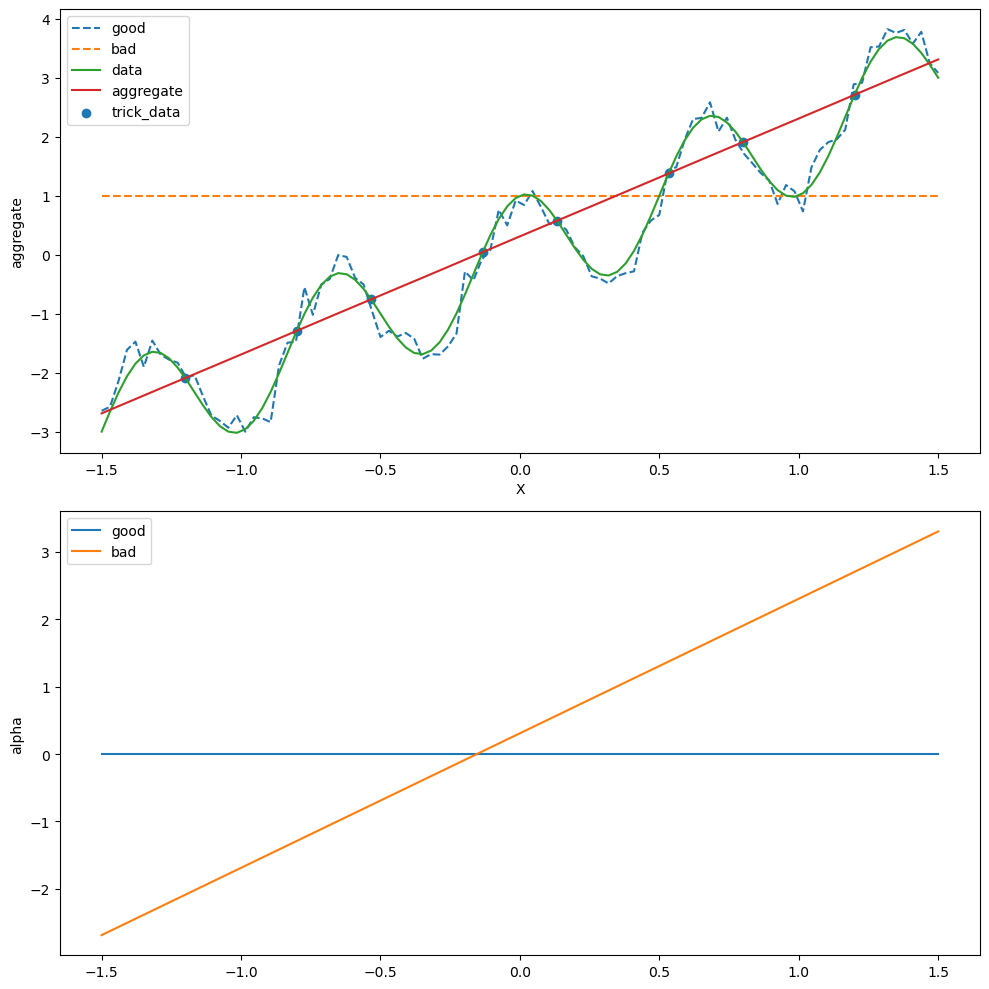

In [230]:
fig=plot_all(aggregate,X,y_target,y_good,y_bad,trick_data,f_target)
plt.show()

# Example 2

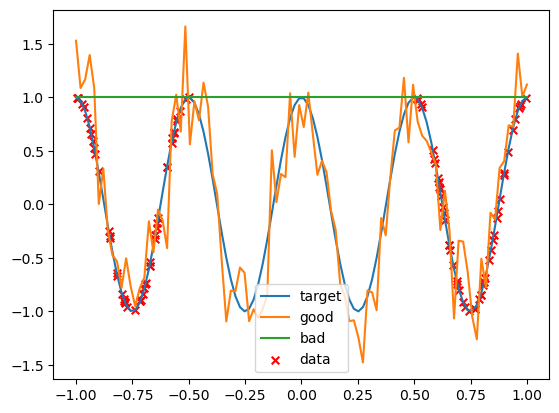

In [236]:
np.random.seed(0)
f_target= lambda x:np.cos(4*np.pi*x)
good_model=lambda x:f_target(x)+np.random.normal(0,0.3,size=x.shape)
bad_model=lambda x:np.ones_like(x)
X=np.linspace(-1,1,100)
y_target=f_target(X)
y_good=good_model(X)
y_bad=bad_model(X)

N=100
data=np.concatenate([np.random.rand(N//2)/2-1,np.random.rand(N//2)/2+1/2])

#plot
plt.plot(X,y_target,label='target')
plt.plot(X,y_good,label='good')
plt.plot(X,y_bad,label='bad')
plt.scatter(data,f_target(data),label='data',s=30,color='r',marker='x')
plt.legend()
plt.show()

In [237]:

def gaussian_separable_kernel(x,y,mat,l):
    K=rbf_kernel(x,y,gamma=1/l**2)+0.1
    return K[:,:,None,None]*mat[None,None,:,:]

my_kernel=partial(gaussian_separable_kernel,mat=np.eye(2),l=1)

In [238]:
aggregate=Agregator(K=my_kernel,models=[wrapper(good_model),wrapper(bad_model)],kernel_name='gaussian',intercept_choice='fit')

In [239]:
aggregate=aggregate.fit(data[:,None],f_target(data),alpha=1e-9)

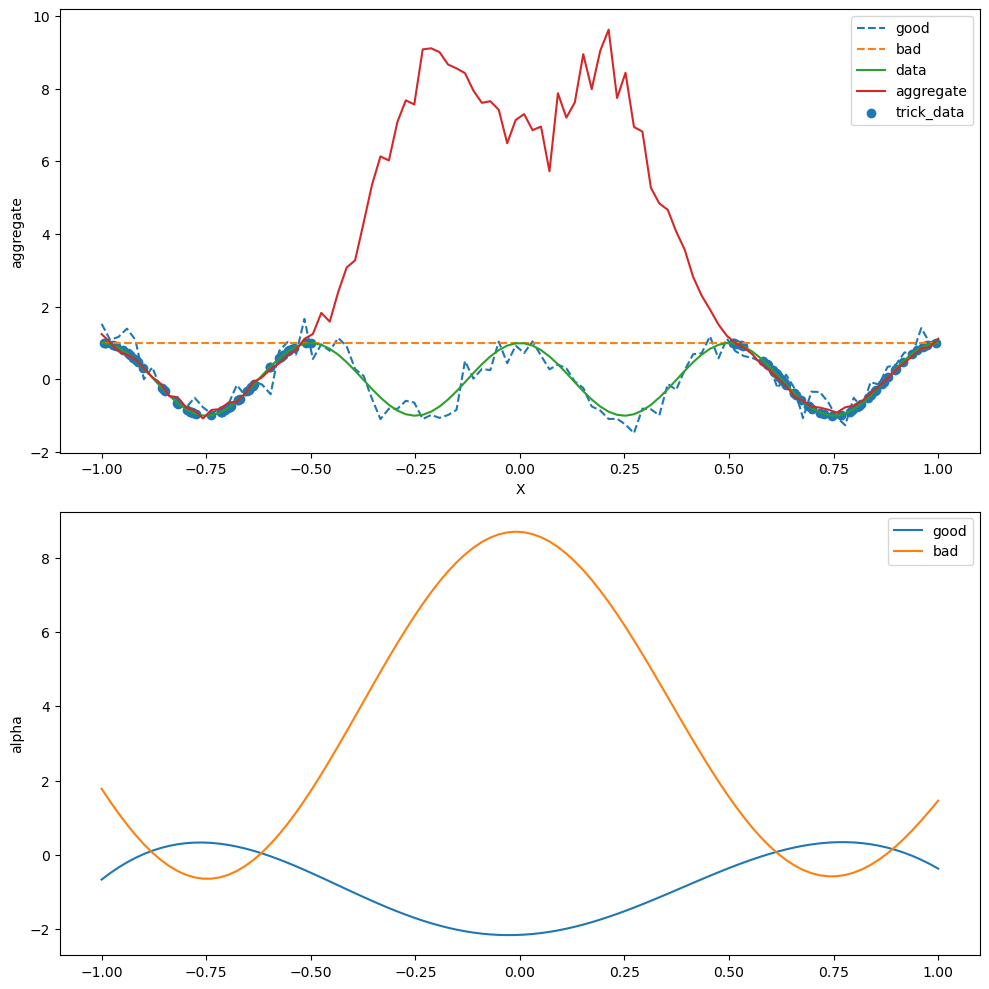

In [240]:
fig=plot_all(aggregate,X,y_target,y_good,y_bad,data,f_target)
plt.show()

# Example 3

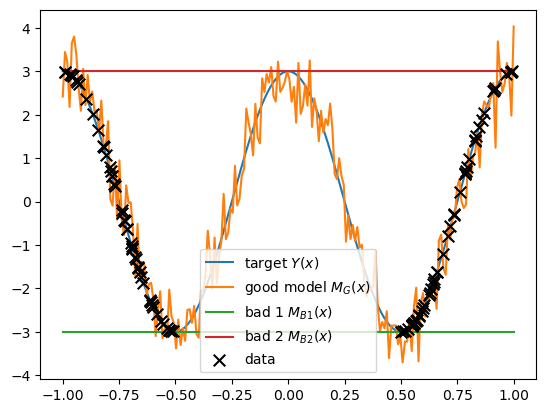

In [35]:
np.random.seed(0)
f_target= lambda x:np.cos(2*np.pi*x)*3
good_model=lambda x:f_target(x)+np.random.normal(0,0.5,size=x.shape)#*(x>0)
bad_model_1=lambda x:-3*np.ones_like(x)
bad_model_2=lambda x:3*np.ones_like(x)
X=np.linspace(-1,1,200)
y_target=f_target(X)
y_bad_1=bad_model_1(X)
y_bad_2=bad_model_2(X)

N=100
data=np.concatenate([np.random.rand(N//2)/2-1,np.random.rand(N//2)/2+1/2])
all_good=good_model(np.concatenate([X,data]))
y_good=all_good[:X.shape[0]]
y_good_data=all_good[X.shape[0]:]

#plot
plt.plot(X,y_target,label='target $Y(x)$')
plt.plot(X,y_good,label='good model $M_G(x)$')
plt.plot(X,y_bad_1,label='bad 1 $M_{B1}(x)$')
plt.plot(X,y_bad_2,label='bad 2 $M_{B2}(x)$')
plt.scatter(data,f_target(data),label='data',s=70,color='k',marker='x',zorder=10)
plt.legend(loc='lower center')
plt.show()

In [101]:
l=1.0
def k(x,y):
    return rbf_kernel(x[:,None],y[:,None],gamma=1/l**2)
K_mat=k(data,data)

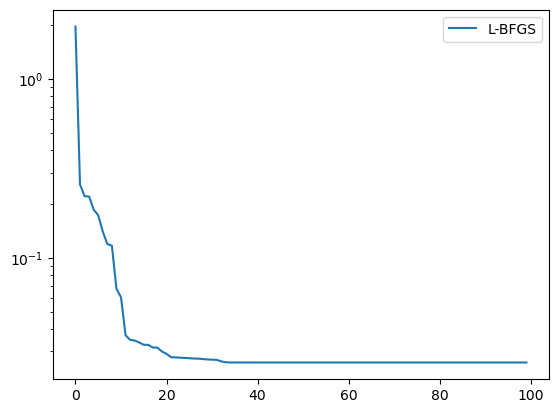

In [106]:


K_mat_torch=torch.tensor(K_mat,dtype=torch.float32)
targets=torch.tensor(f_target(data),dtype=torch.float32)
model_values=torch.tensor([y_good_data,bad_model_1(data),bad_model_2(data)],dtype=torch.float32)



lam=0.1
def loss_fn(V):
    pred = torch.matmul(K_mat_torch, V[:-1])+V[-1]
    pred = torch.softmax(pred, dim=1)
    aggregate=torch.sum(pred*model_values.T,dim=1)
    return torch.mean((aggregate-targets)**2)+lam*torch.mean(V**2)




# L-BFGS
def closure():
    lbfgs.zero_grad()
    objective = loss_fn(V1)
    objective.backward()
    return objective

V1=torch.rand(N+1,3)
V1.requires_grad=True

lbfgs = optim.LBFGS([V1],
                    history_size=10, 
                    max_iter=4, 
                    line_search_fn="strong_wolfe")
                    
history_lbfgs = []
for i in range(100):
    history_lbfgs.append(loss_fn(V1).item())
    lbfgs.step(closure)

                    

# Plotting
plt.figure()
plt.semilogy(history_lbfgs, label='L-BFGS')
plt.yscale('log')
plt.legend()
plt.show()

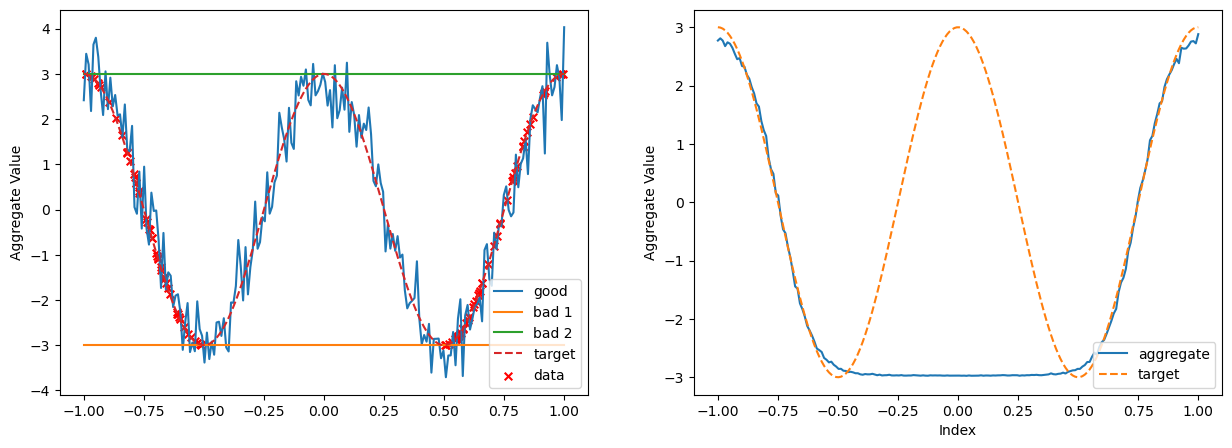

In [119]:
K_eval=k(X,data)
pred_eval=torch.matmul(torch.tensor(K_eval,dtype=torch.float32),V1[:-1])+V1[-1]
pred_eval_soft=torch.softmax(pred_eval,dim=1)
model_values_eval=torch.tensor([y_good,y_bad_1,y_bad_2],dtype=torch.float32)
aggregate_eval=torch.sum(pred_eval_soft*model_values_eval.T,dim=1)






# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot the aggregate in the first subplot
ax1.plot(X,y_good,label='good')
ax1.plot(X,y_bad_1,label='bad 1')
ax1.plot(X,y_bad_2,label='bad 2')
ax1.plot(X,y_target,label='target',linestyle='--')
ax1.scatter(data,f_target(data),label='data',s=30,color='r',marker='x')
ax1.set_ylabel('Aggregate Value')
ax1.legend(loc='lower right')

# Plot the aggregate in the second subplot
ax2.plot(X,aggregate_eval.detach().numpy(),label='aggregate')
ax2.plot(X,y_target,label='target',linestyle='--')
ax2.set_xlabel('Index')
ax2.set_ylabel('Aggregate Value')
#legend with loc in (0,0.75)
ax2.legend(loc='lower right')

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.3)

# Show the plot
plt.show()

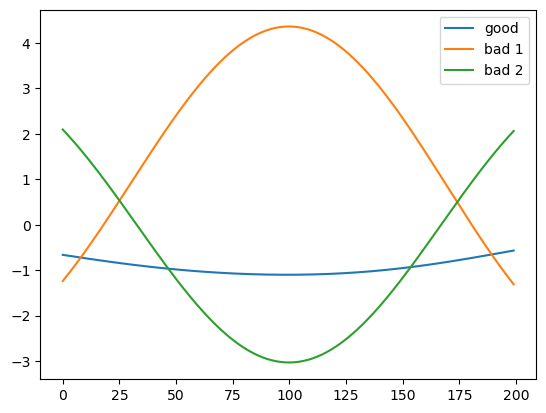

In [108]:
for i,model in enumerate(['good','bad 1','bad 2']):
    plt.plot(pred_eval.detach().numpy()[:,i],label=model)
plt.legend()

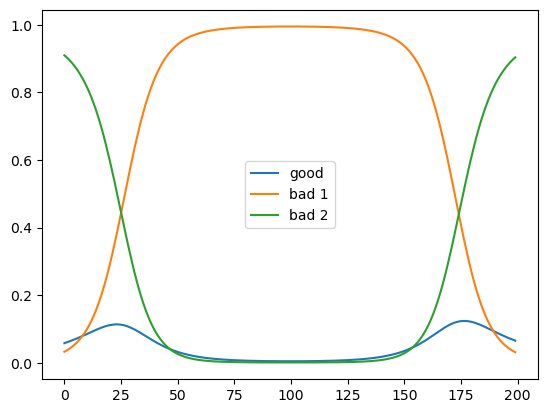

In [109]:
for i,model in enumerate(['good','bad 1','bad 2']):
    plt.plot(pred_eval_soft.detach().numpy()[:,i],label=model)
plt.legend()